# Getting Started: Computer Vision


## Main Computer Vision libraries in Pytorch

* `torchvision`: base domain library for Pytorch computer vision
* `torchvision.datasets`: get datasets and data loading functions for computer vision
* `torchvision.models`: get pretrained computer vision models that you can levarage for your own problems 
* `torchvision.transforms`: functions for manipulating vision data (images) to be suitable for use with an ML model 
* `torch.utils.data.dataset`: base dataset for pytorch 
* `torch.utils.data.dataloader`: creates python iterable over a dataset

In [160]:
import torch
from torch import nn 


import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visualization 

import matplotlib.pyplot as plt 

print(torchvision.__version__)

0.20.1


## Get the dataset 

The dataset for this computer vision project will be FashionMNIST from torchvision.datasets

In [161]:
# Set up training data  

from torchvision import datasets

train_data = datasets.FashionMNIST(
    root = "data", # where to download the data to?
    train = True,  # do we want the training dataset?
    download = True, # Download or not
    transform = ToTensor(),  # how do we want to transform the data?
    target_transform = None # how do we want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True, 
    transform = ToTensor(),
    target_transform = None
)


In [162]:
len(train_data), len(test_data)

(60000, 10000)

In [163]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Visualizing Data 

(-0.5, 27.5, 27.5, -0.5)

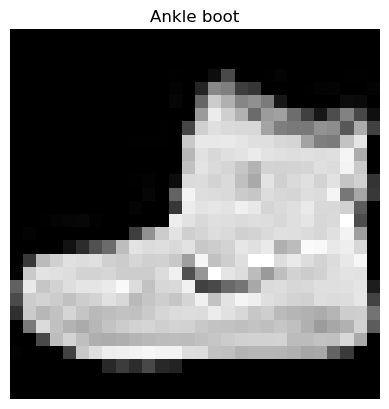

In [164]:
import matplotlib.pyplot as plt
image,label = train_data[0]

plt.imshow(image.squeeze()) # using squeeze because data is in format of [1,28,28] 1 being color channels
# imshow only takes the height width and then color channels or just height or width so we are using squeeze to get the desired input

plt.title(label)

plt.imshow(image.squeeze(), cmap="gray") # doing grayscale
plt.title(class_names[label])
plt.axis(False)

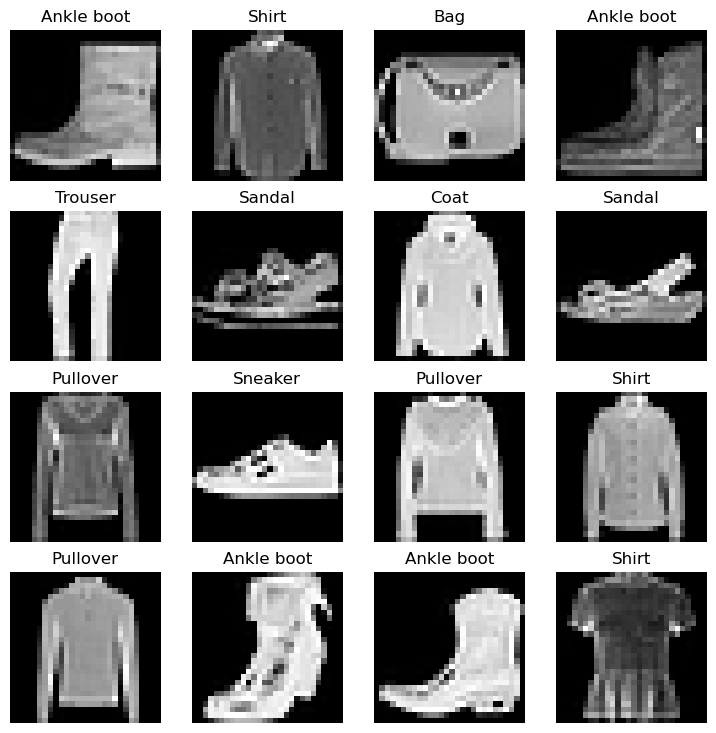

In [165]:
torch.manual_seed(42)

row, columns = 4,4 

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4 

for i in range(1, cols*rows + 1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Preparing the Dataloader 

Right now our data is in the form of Pytorch Dataset.

Dataloader turns our dataset into a Python Iterable 

More specifically, we want to turn our dataset into batches (or mini-batches)

We want to do this for these reasons:

1. It is more computationally efficient, computing hardware might not be able to take in all 60000+ samples at once so we break it into mini batches (usually around 32) <br>
2. It gives neural network more chances to update its gradient per epoch to get better results

In [166]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset= train_data, 
                              batch_size= 32,
                              shuffle= True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False) # For evaulation its better to not shuffle the testing data because the model will never see the test data in training


In [167]:
# Check out whats inside the training dataloader 

train_features_batch, train_labels_batch = next(iter(train_dataloader)) 
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Creating a Baseline Model

When starting to build a model in machine learning you want to start with a baseline model.

This type of model is a simple model that you can add more bells and whistles to as you conitnue to experiment.

In other words: start simply and add compleixty when necesary

In [168]:
# Create a flatten layer 
flatten_model = nn.Flatten()

# Get a single output 
x = train_features_batch[0]

#flatten a sample
output = flatten_model(x) # turn the shape of the output from [1,28,28] to [1,784] basically going from [color channel, height, width] to
# [color channnel, height*width] essentially mapping for each pixel --- essentially we're turning this into a single vector space

# Why are we doing this? We want to apply our data through a linear layer which can't handle multidimensional data as it needs single dimenionsal input

In [169]:
from torch import nn

class fashionMNISTModelV0(nn.Module):
    def __init__(self , input_shape: int , hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # we flatten the external dimensions
            nn.Linear(in_features=input_shape, out_features= hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)
    

In [170]:
device = "cpu"

if(torch.mps.is_available()):
    device = "mps"
elif (torch.cuda.is_available()):
    device = "cuda"

model_0 = fashionMNISTModelV0(input_shape = 784, # this is 28x28
                              hidden_units=10,
                              output_shape= len(class_names)).to(device)




### Setup Loss, Optimizer, and Evaluation Metrics

- Loss function: since we're working with mutliclass classification, we can just use `nn.CrossEntropyLoss()`
- Optimizer: our optimizer `torch.optim.SGD` (stochastic gradient descent)
- Evaluation Metric: since we're working on classification, accuracy will be our main metric 

In [171]:
import torchmetrics 

from torchmetrics import Accuracy 

#setup loss
loss_fn = nn.CrossEntropyLoss()

#setup optimizer 
optimizer = torch.optim.SGD(params= model_0.parameters(), lr= 0.01)

accuracy_fn = Accuracy(task="multiclass", num_classes= 10).to(device=device)


## Creating a  function to time experiments

Because machine learning is very experimental, the two metrics that we want to track are:

1. Model's performance (loss, accuracy,etc)
2. How fast it runs

Ideal Conditions -> High Performance fast model

In [172]:
from timeit import default_timer as timer   

def print_train_time(start:float , end:float , device: torch.device = None):
    total_time = end - start
    print(f"total time on {device}: {total_time:.3f} seconds")

    return total_time



## Creating a training loop and training a model on batches of data 

1. Loop through epochs (note that the optimizer will be updating once per batch independantly of epochs)
2. Loop through training batches, perform training steps, calculate the train loss *per batch* 
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out whats happening and time it all


In [173]:
# import tqdm for a progress bar 

from tqdm.auto import tqdm # auto gets the best progress bar for whatever settings your using 

#set the seed and start the timer

torch.manual_seed(42)
torch.mps.manual_seed(42)

start_time = timer()

# set the number of epochs (want to keep this relativly small to have fast training times to fine tune the model)
epochs = 3

# creating training and testing loop 

for epoch in tqdm(range(epochs)): # we just need to wrap our tqdm with what we're iterating over

    # Training 

    training_loss = 0

    # add a loop to loop through the training batches

    for batch, (X, y) in enumerate(train_dataloader): # its common to keep your features as X and labels as y
        model_0.train()
        X, y = X.to(device), y.to(device)
        
        # Forward Pass
        y_pred = model_0(X)

        # Calculate the loss (per batch )
        loss = loss_fn(y_pred, y)
        training_loss += loss # aggregating the loss per batch in order ot get the total loss across all our samples 

        # Zero grad
        optimizer.zero_grad()

        # Backpropagation 
        loss.backward()

        # Stochasitc Gradient Descent
        optimizer.step()
        

        # print out whats happening
        if batch % 400 == 0: 
            print(f"Amount of Data Looked At: {batch * len(x)} / {len(train_dataloader.dataset)} samples")

    #divide total train loss  by length of the data loader
    training_loss /= len(train_dataloader)

    # Testing
    model_0.eval()
    
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X_test,y_test in test_dataloader:

            X_test, y_test = X_test.to(device), y_test.to(device)
            #1. forward pass

            test_pred = model_0(X_test)

            #2. Calculate the loss / accuracy

            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(test_pred, y_test).item()

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    # Print out whats happening
    print(f"\n Train Loss: {training_loss:.4f} | Test Loss: {test_loss: .4f} , Test Accuracy: {test_acc:.4f} ")

#calculate training time

end_time = timer()

total_train_time = print_train_time(start_time, end_time, device= str(next(model_0.parameters()).device))




  0%|          | 0/3 [00:00<?, ?it/s]

Amount of Data Looked At: 0 / 60000 samples
Amount of Data Looked At: 400 / 60000 samples
Amount of Data Looked At: 800 / 60000 samples
Amount of Data Looked At: 1200 / 60000 samples
Amount of Data Looked At: 1600 / 60000 samples


 33%|███▎      | 1/3 [00:05<00:10,  5.32s/it]


 Train Loss: 0.8902 | Test Loss:  0.6286 , Test Accuracy: 0.7818 
Amount of Data Looked At: 0 / 60000 samples
Amount of Data Looked At: 400 / 60000 samples
Amount of Data Looked At: 800 / 60000 samples
Amount of Data Looked At: 1200 / 60000 samples
Amount of Data Looked At: 1600 / 60000 samples


 67%|██████▋   | 2/3 [00:10<00:05,  5.23s/it]


 Train Loss: 0.5624 | Test Loss:  0.5462 , Test Accuracy: 0.8094 
Amount of Data Looked At: 0 / 60000 samples
Amount of Data Looked At: 400 / 60000 samples
Amount of Data Looked At: 800 / 60000 samples
Amount of Data Looked At: 1200 / 60000 samples
Amount of Data Looked At: 1600 / 60000 samples


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


 Train Loss: 0.5066 | Test Loss:  0.5139 , Test Accuracy: 0.8204 
total time on mps:0: 15.758 seconds


## Make Predictions and get Model Results

In [174]:
torch.manual_seed(42)

def ModelEval(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    loss, acc = 0,0

    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            # make predictions
            X,y = X.to(device), y.to(device)
            y_pred = model(X)

            # Accumilate loss/accuracy 

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim =1), y).item()
        
        # scale the loss and accuracy to find the loss/accuracy per batch
            
        loss /= len(data_loader)
        acc /= len(data_loader)
    

    return {"model_name": model.__class__.__name__,
            "loss": loss.item(),
            "accuracy": acc}



model_0_results = ModelEval(model=model_0.to(device), data_loader= test_dataloader, loss_fn= loss_fn.to(device), accuracy_fn=accuracy_fn)

print(model_0_results)


{'model_name': 'fashionMNISTModelV0', 'loss': 0.5138769745826721, 'accuracy': 0.8203873801916933}


## Building a better model with Non-Linearity

In [175]:
# Create a model with non-linear and linear layers
import torch
from torch import nn

class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_units: int, hidden_units: int, output_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= output_units),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

model_1 = FashionMNISTModelV2(input_units=784, hidden_units=10, output_units=len(class_names)).to(device)

## Setup Loss, Optimizer, and Evaluation Metrics

In [176]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

accuracy_fn = Accuracy(task="multiclass", num_classes= 10)

In [177]:
def train_loop(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn, 
               device: torch.device = device):
    
    training_loss, training_acc = 0 , 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        
        y = torch.tensor(y)
        X , y = X.to(device) , y.to(device)
        
        # forward pass
        y_pred = model(X).to(device)

        # calculate loss
        loss = loss_fn(y_pred, y)
        training_loss += loss 
        acc = accuracy_fn(y_pred, y)
        training_acc += acc
        
        # zero grad
        optimizer.zero_grad()

        # backpropogation
        loss.backward()

        # gradient descent
        optimizer.step()

    # get loss perbatch 
        
    training_loss /= len(data_loader)
    training_acc /= len(data_loader)

    # print everything out
    print(f"Train Loss: {training_loss:.5f} | Train Accuracy: {training_acc:.5f}")



        
    


In [178]:
def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              accuracy_fn,
              loss_fn = torch.nn.Module,
              optimizer = torch.optim.Optimizer,
              device: torch.device = device):
    

    test_loss, test_acc = 0,0

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:

            X_test, y_test = X_test.to(device), y_test.to(device)

            #forward step
            test_pred = model(X_test)

            # calc loss and acc
            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            acc = accuracy_fn(test_pred.argmax(dim = 1), y_test)
            test_acc += acc

    # print out whats happening 
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
            
    print(f"Testing Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}")






In [179]:
# replicating functionality of training and testing loop but with created function

torch.manual_seed(42)

epochs = 3

start_timer = timer()

device = "mps" if torch.mps.is_available() else "cpu"


for epoch in tqdm(range(epochs)):

    train_loop(model = model_1.to(device),
            data_loader= train_dataloader,
            accuracy_fn = accuracy_fn.to(device),
            loss_fn = loss_fn,
            optimizer= optimizer,
            device = device)

    test_loop(model= model_1.to(device), 
                data_loader= test_dataloader, 
                accuracy_fn = accuracy_fn.to(device),
                loss_fn=  loss_fn, 
                optimizer= optimizer,
                device= device)
    
   
    

end_time = timer()

total_train_time_model01 = print_train_time(start= start_time, end= end_time, device = device)


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/34/8lq_66rx1bdchmr52gb_th440000gn/T/ipykernel_1845/2622372808.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


Train Loss: 1.66754 | Train Accuracy: 0.43575


 33%|███▎      | 1/3 [00:09<00:18,  9.29s/it]

Testing Loss: 1.20825 | Test Accuracy: 0.59
Train Loss: 0.94339 | Train Accuracy: 0.69153


 67%|██████▋   | 2/3 [00:18<00:09,  9.43s/it]

Testing Loss: 0.83634 | Test Accuracy: 0.72
Train Loss: 0.77233 | Train Accuracy: 0.73770


100%|██████████| 3/3 [00:26<00:00,  8.99s/it]

Testing Loss: 0.76537 | Test Accuracy: 0.73
total time on mps: 43.843 seconds


 **Note:** Sometimes depending on the hardware, the GPU might run slower than the CPU 

 This can be for these two main reasons:
  1. It could be that the overhead of copying the data/model to and from the GPU outweighs the compute benefits offered by the GPU
  2. Hardware being used is structured such that cpu is better than gpu (very sad reality) 

In [180]:
# Get model_1 results dictionary


print(ModelEval(model_1,test_dataloader,loss_fn, accuracy_fn=accuracy_fn))

print(ModelEval(model_0,test_dataloader,loss_fn, accuracy_fn=accuracy_fn))

model_1_results = ModelEval(model= model_1, data_loader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn)

{'model_name': 'FashionMNISTModelV2', 'loss': 0.7653749585151672, 'accuracy': 0.7310303514376997}
{'model_name': 'fashionMNISTModelV0', 'loss': 0.5138769745826721, 'accuracy': 0.8203873801916933}


## Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNet's 

CNN's are known for their capabilities to find patterns in visual data 



In [181]:
# create a convolutional nueral network

class FashionMINSTV3(nn.Module):
    """
        Model Architexture that replicates TinyVGG 
        Model from CNN Explainer Website 
    """

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, 
                      out_channels= hidden_units, 
                      kernel_size= 3,
                      padding= 1,
                      stride= 1), #these are hyperparameters -- values we can set ourselves
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride = 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,
                         stride= 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units*  7*7,
                      out_features = output_shape),
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)

        x = self.classifier(x)

        return x





model_2 = FashionMINSTV3(input_shape= 1, output_shape= len(class_names), hidden_units=10).to(device)

model_2

FashionMINSTV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## How do I figure out the in_features of the last layer, the classification part


You need to print it out, you could calculate it based on plugging it into the math but its far easier to print it out and go from there.

This is because a tensor image of shape (3,28,28) will have a different in_feature in that classification layer than a tensor of shape (3,64,64)

## Setting up the loss and optimizer for model_2

In [182]:
torch.manual_seed(42)



loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model_2.parameters(), lr = 0.01)


epochs = 3

start_time = timer()


for epoch in tqdm(range(epochs)):

    train_loop(model = model_2,
               data_loader= train_dataloader,
               loss_fn = loss_fn,
               optimizer= optimizer,
               accuracy_fn= accuracy_fn,
               device= device)
    
    test_loop(model = model_2,
               data_loader= test_dataloader,
               loss_fn = loss_fn,
               optimizer= optimizer,
               accuracy_fn= accuracy_fn,
               device= device)
    

end_time = timer()

model_2_training_time = print_train_time(start= start_time, end = end_time, device= device)

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/34/8lq_66rx1bdchmr52gb_th440000gn/T/ipykernel_1845/2622372808.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


Train Loss: 1.69823 | Train Accuracy: 0.35615


 33%|███▎      | 1/3 [00:07<00:15,  7.95s/it]

Testing Loss: 0.72513 | Test Accuracy: 0.73
Train Loss: 0.62323 | Train Accuracy: 0.77727


 67%|██████▋   | 2/3 [00:15<00:07,  7.95s/it]

Testing Loss: 0.54426 | Test Accuracy: 0.80
Train Loss: 0.48051 | Train Accuracy: 0.82758


100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

Testing Loss: 0.45869 | Test Accuracy: 0.84
total time on mps: 24.460 seconds


In [183]:
# get results dictionary

model_2_results = ModelEval(model= model_2, data_loader= test_dataloader, loss_fn = loss_fn, accuracy_fn= accuracy_fn)

model_2_results

{'model_name': 'FashionMINSTV3',
 'loss': 0.45868533849716187,
 'accuracy': 0.8404552715654952}

In [184]:
model_0_results

{'model_name': 'fashionMNISTModelV0',
 'loss': 0.5138769745826721,
 'accuracy': 0.8203873801916933}

## Compare Results and Traning Time

In [185]:
import pandas as pd 

compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])

compare_results


,model_name,loss,accuracy
0,fashionMNISTModelV0,0.513877,0.820387
1,FashionMNISTModelV2,0.765375,0.731030
2,FashionMINSTV3,0.458685,0.840455


In [186]:
# add total train time to results comparison

compare_results["training_time"] =  [total_train_time,
                                     total_train_time_model01,
                                     model_2_training_time]

compare_results

,model_name,loss,accuracy,training_time
0,fashionMNISTModelV0,0.513877,0.820387,15.757516
1,FashionMNISTModelV2,0.765375,0.731030,43.843221
2,FashionMINSTV3,0.458685,0.840455,24.459866


Text(0, 0.5, 'model')

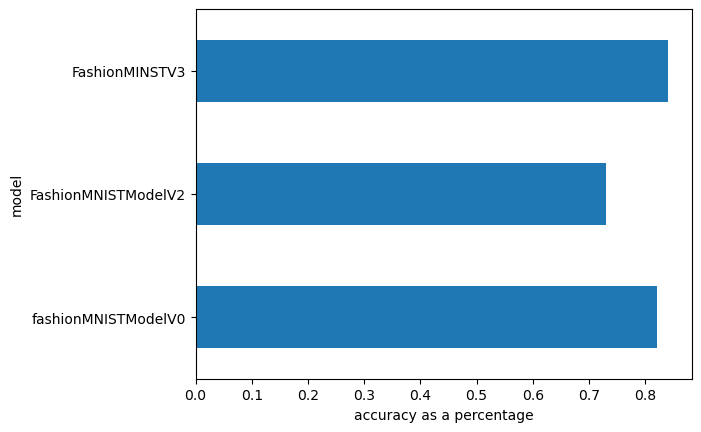

In [188]:
compare_results.set_index("model_name")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [257]:
def make_predictions(model: torch.nn.Module, 
                     data: list, 
                     device: torch.device = device):
    pred_probs = []

    model.eval()

    with torch.inference_mode():
        for sample in data:
            #prepare the sample (add a batch dimension and send to device)

            sample = torch.unsqueeze(sample, dim =0).to(device)

            #forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # get prediciton probability (logit -> prediction probabilty)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim =0)

            # get pred_prob off of gpu

            pred_probs.append(pred_prob.cpu())
    
    #stack pred_probs to make list into tensor
            
    return torch.stack(pred_probs) 



In [258]:
import random



test_samples =[]
test_labels = []

for samples, label in random.sample(list(test_data), k=9):
    test_samples.append(samples)
    test_labels.append(label)


pred_probs = make_predictions(model= model_2, data = test_samples, device= device)

pred_classes = pred_probs.argmax(dim = 1)

pred_classes


tensor([6, 9, 2, 2, 9, 5, 6, 6, 6])

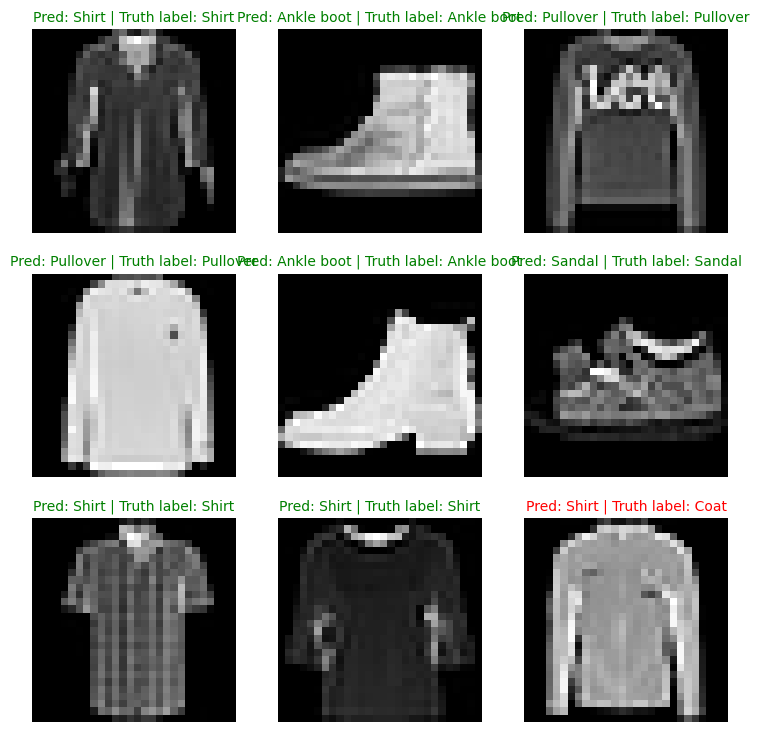

In [260]:
# plot predictions

plt.figure(figsize=(9,9))

nrows = 3

ncols = 3

for i, sample in enumerate(test_samples):
    # create subplot
    plt.subplot(nrows,ncols, i+1)

    # plot target image
    plt.imshow(sample.squeeze() , cmap="gray")

    #Find the prediction in text form 

    pred_label = class_names[pred_classes[i]]

    # get the truth label (in text form )

    truth_label = class_names[test_labels[i]]

    # create a title for the plot

    title_text = f"Pred: {pred_label} | Truth label: {truth_label}"

    #check for equality and change color of the truth label based on that 

    if pred_label == truth_label:
        plt.title(title_text, fontsize = 10, c="g") # green text if prediction is truth
    else:
        plt.title(title_text, fontsize= 10, c="r")

    plt.axis(False)

